In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [3]:
df80 = pd.read_csv('angulo-voltaje80.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df80.astype(float)

,Angulos,Voltaje
0,0.18,0.70
1,0.35,0.72
2,0.53,0.71
3,0.70,0.71
4,0.88,0.71
...,...,...
449,79.10,0.72
450,79.28,0.71
451,79.45,0.72
452,79.63,0.71


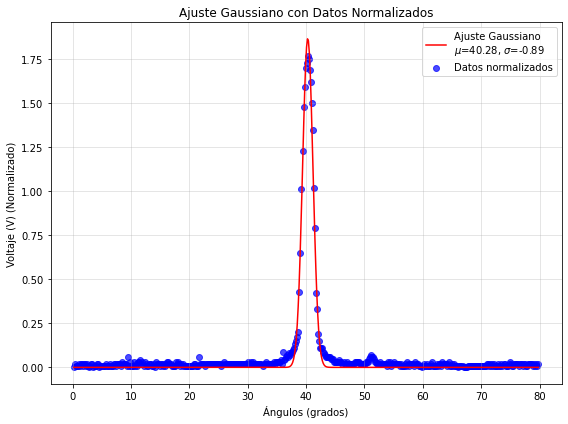

In [4]:
# Restar el nivel mínimo de fondo a todos los datos
background_level = df80["Voltaje"].min()
df80["Voltaje_normalizado"] = df80["Voltaje"] - background_level

x_data = df80["Angulos"]
y_data_normalized = df80["Voltaje_normalizado"]

# Ajustar la función gaussiana a los datos normalizados
initial_guess = [y_data_normalized.max(), x_data[y_data_normalized.idxmax()], np.std(x_data)]
params, covariance = curve_fit(gaussian, x_data, y_data_normalized, p0=initial_guess)

# Obtener parámetros ajustados
A, mu, sigma = params
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = gaussian(x_fit, A, mu, sigma)

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data_normalized, color='blue', label='Datos normalizados', alpha=0.7)
plt.plot(x_fit, y_fit, color='red', label=f'Ajuste Gaussiano\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}')
plt.title("Ajuste Gaussiano con Datos Normalizados")
plt.xlabel("Ángulos (grados)")
plt.ylabel("Voltaje (V) (Normalizado)")
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ajustar_gaussiana(df, angulo_col, voltaje_col, umbral_min=0):
    """
    Ajusta una gaussiana a los datos de un DataFrame, grafica los resultados y retorna los parámetros ajustados.
    
    Parámetros:
    - df: DataFrame con los datos a analizar.
    - angulo_col: Nombre de la columna con los datos de ángulos.
    - voltaje_col: Nombre de la columna con los datos de voltaje.
    - umbral_min: Valor mínimo para normalizar el voltaje (nivel de fondo). Por defecto usa el mínimo del voltaje.
    
    Retorna:
    - mu: Media de la gaussiana ajustada.
    - sigma: Desviación estándar de la gaussiana ajustada.
    """
    # Normalizar los datos de voltaje
    background_level = umbral_min if umbral_min > 0 else df[voltaje_col].min()
    df["Voltaje_normalizado"] = df[voltaje_col] - background_level
    
    # Definir los datos para el ajuste
    x_data = df[angulo_col]
    y_data = df["Voltaje_normalizado"]
    
    # Definir la función gaussiana
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    
    # Estimación inicial para el ajuste
    initial_guess = [y_data.max(), x_data[y_data.idxmax()], np.std(x_data)]
    
    # Realizar el ajuste gaussiano
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    A, mu, sigma = params
    
    # Crear los datos ajustados para la gráfica
    x_fit = np.linspace(min(x_data), max(x_data), 500)
    y_fit = gaussian(x_fit, A, mu, sigma)
    
    # Generar la gráfica
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color='blue', label='Datos Normalizados', alpha=0.7)
    plt.plot(x_fit, y_fit, color='red', label=f'Ajuste Gaussiano\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}')
    plt.title("Ajuste Gaussiano al Gráfico de Voltaje vs Ángulo")
    plt.xlabel("Ángulos (grados)")
    plt.ylabel("Voltaje (V) (Normalizado)")
    plt.legend(loc='best')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    # Retornar parámetros ajustados
    return mu, sigma

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ajustar_gaussiana2(df, angulo_col, voltaje_col, quantile=0.5):
    """
    Ajusta una gaussiana a los datos de un DataFrame, calcula el error en la desviación estándar,
    normaliza los datos al 0 utilizando un umbral basado en el cuantíl,
    grafica los resultados y retorna los parámetros ajustados junto con sus errores.
    
    Parámetros:
    - df: DataFrame con los datos a analizar.
    - angulo_col: Nombre de la columna con los datos de ángulos.
    - voltaje_col: Nombre de la columna con los datos de voltaje.
    - quantile: Cuantíl para establecer el umbral de normalización. Por defecto, se usa el 5% (0.05).
    
    Retorna:
    - mu: Media de la gaussiana ajustada.
    - sigma: Desviación estándar de la gaussiana ajustada.
    - error_mu: Error en la media de la gaussiana.
    - error_sigma: Error en la desviación estándar de la gaussiana.
    """
    # Normalización de los datos usando el cuantíl
    threshold = np.quantile(df[voltaje_col], quantile)
    df["Voltaje_normalizado"] = df[voltaje_col] - threshold
    
    # Definir los datos para el ajuste
    x_data = df[angulo_col]
    y_data = df["Voltaje_normalizado"]
    
    # Definir la función gaussiana
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    
    # Estimación inicial para el ajuste
    initial_guess = [y_data.max(), x_data[y_data.idxmax()], np.std(x_data)]
    
    # Realizar el ajuste gaussiano
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    A, mu, sigma = params
    
    # Calcular los errores de los parámetros a partir de la matriz de covarianza
    error_mu = np.sqrt(covariance[1, 1])  # Error de la media
    error_sigma = np.sqrt(covariance[2, 2])  # Error en la desviación estándar
    
    # Crear los datos ajustados para la gráfica
    x_fit = np.linspace(min(x_data), max(x_data), 500)
    y_fit = gaussian(x_fit, A, mu, sigma)
    
    # Generar la gráfica
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, color='blue', label='Datos Normalizados', alpha=0.7)
    plt.plot(x_fit, y_fit, color='red', label=f'Ajuste Gaussiano\n$\mu$={mu:.2f} $\pm$ {error_mu:.2f}, $\sigma$={sigma:.2f} $\pm$ {error_sigma:.2f}')
    plt.title("Ajuste Gaussiano al Gráfico de Voltaje vs Ángulo")
    plt.xlabel("Ángulos (grados)")
    plt.ylabel("Voltaje (V) (Normalizado)")
    plt.legend(loc='best')
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    # Retornar parámetros ajustados y sus errores
    return mu, sigma, error_mu, error_sigma

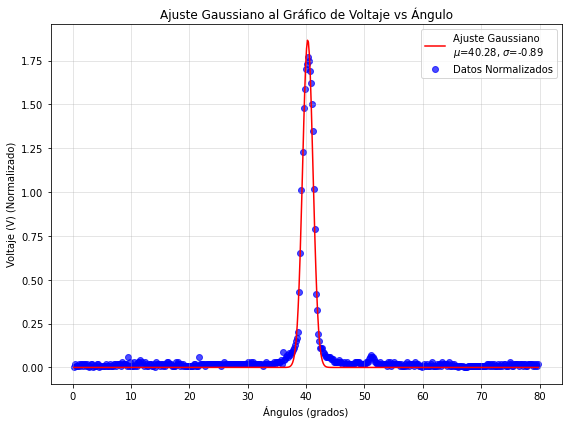

Media (mu): 40.28
Desviación estándar (sigma): -0.89


In [31]:
# Cargar datos
df = pd.read_csv('angulo-voltaje80.txt', sep='\s+', header=None, skiprows=1, names=['Angulos', 'Voltaje'])
df = df.astype(float)

# Llamar a la función
mu, sigma = ajustar_gaussiana(df, 'Angulos', 'Voltaje')

print(f"Media (mu): {mu:.2f}")
print(f"Desviación estándar (sigma): {sigma:.2f}")


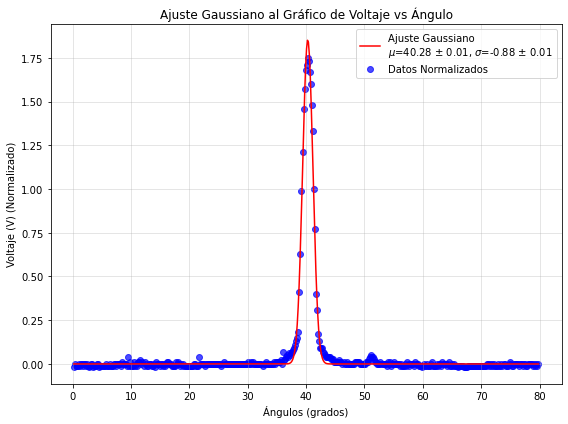

Media (mu): 40.28
Desviación estándar (sigma): -0.88


In [32]:
# Cargar datos
df = pd.read_csv('angulo-voltaje80.txt', sep='\s+', header=None, skiprows=1, names=['Angulos', 'Voltaje'])
df = df.astype(float)

# Llamar a la función
mu, sigma, error_mu, error_sigma = ajustar_gaussiana2(df, 'Angulos', 'Voltaje')

print(f"Media (mu): {mu:.2f}")
print(f"Desviación estándar (sigma): {sigma:.2f}")

In [33]:
df80 = pd.read_csv('angulo-voltaje80.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df80.astype(float)

df90 = pd.read_csv('angulo-voltaje90.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df90.astype(float)

df100 = pd.read_csv('angulo-voltaje100.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df100.astype(float)

df110 = pd.read_csv('angulo-voltaje110.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df110.astype(float)

df120 = pd.read_csv('angulo-voltaje120.txt', sep='\s+', header=None,
                  skiprows=1, names=['Angulos', 'Voltaje'])
df120.astype(float)

,Angulos,Voltaje
0,0.18,0.71
1,0.35,0.71
2,0.53,0.70
3,0.70,0.71
4,0.88,0.71
...,...,...
676,119.00,0.71
677,119.18,0.72
678,119.36,0.72
679,119.53,0.71


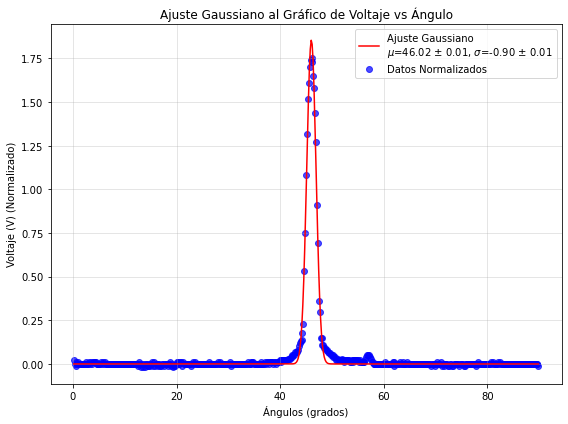

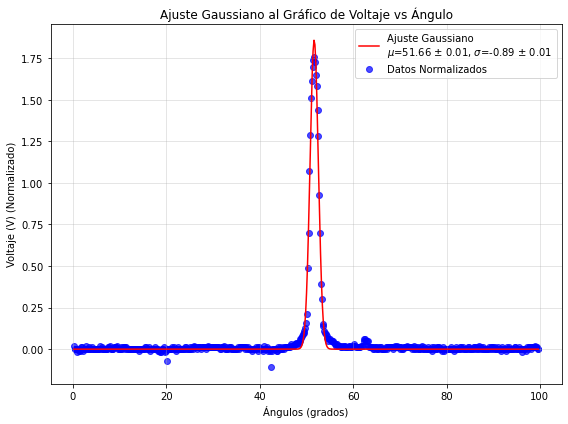

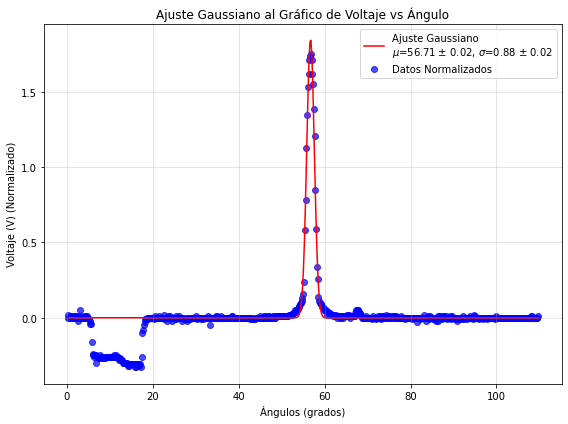

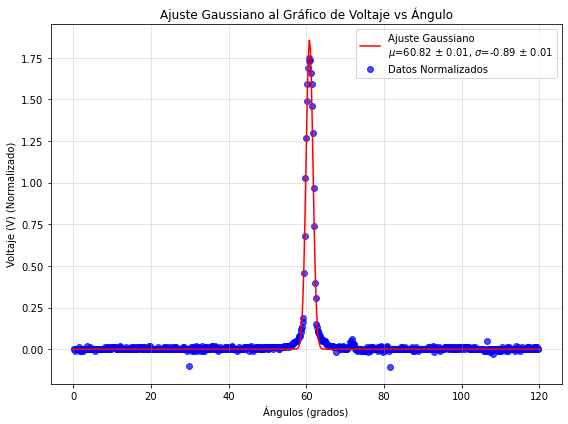

In [34]:
mu90, sigma90, error_mu90, error_sigma90 = ajustar_gaussiana2(df90, 'Angulos', 'Voltaje')

mu100, sigma100, error_mu, error_sigma = ajustar_gaussiana2(df100, 'Angulos', 'Voltaje')

mu110, sigma110, error_mu, error_sigma = ajustar_gaussiana2(df110, 'Angulos', 'Voltaje')

mu120, sigma120, error_mu, error_sigma = ajustar_gaussiana2(df120, 'Angulos', 'Voltaje')